In [1]:
from math import sqrt
from numpy import concatenate
import numpy as np
import matplotlib.pyplot as pyplot
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error


data_set = pd.read_csv('/Users/shenghaoisyummy/Capstone/feature_extraction_data_dummis_all.csv', index_col=0)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def time_to_total_minutes(df):
    df['target_minitues'] = df['actual_station_arrv_time_hours'] * 60 + df['actual_station_arrv_time_minutes']

time_to_total_minutes(data_set)
data_set['target_minitues']

1          1436
2             5
3             9
4            19
5            23
6            25
7            29
8            34
9            38
10           47
11           60
12           64
13           66
14           68
15           74
16           84
17           86
18           88
19           91
20           96
21           99
22          110
23          117
24          126
25          131
26          139
27          146
28          152
29          154
30          157
           ... 
1046741    1171
1046742    1176
1046743    1184
1046744    1192
1046745    1198
1046746    1201
1046747    1203
1046748    1205
1046749    1210
1046750    1215
1046751    1217
1046752    1220
1046753    1223
1046754    1228
1046755    1231
1046756    1235
1046757    1241
1046758    1248
1047008     427
1047009     428
1047010     432
1047011     440
1047012     451
1047013     466
1047014     481
1047015     485
1047016     498
1047017     506
1047018     527
1047019     540
Name: target_minitues, L

In [3]:
data_Y = data_set[['target_minitues']]
data_set.drop(['actual_station_arrv_time_hours','actual_station_arrv_time_minutes', 'arrv_late_time', 'dprt_late_time', 'actual_station_dprt_time_hours', 'actual_station_dprt_time_minutes', 'target_minitues'], axis=1, inplace=True)

In [4]:
data_X = data_set
data_X.shape

(69197, 229)

In [5]:
data_Y.values

array([[1436],
       [   5],
       [   9],
       ...,
       [ 506],
       [ 527],
       [ 540]], dtype=int64)

In [6]:
# make sure value as float
data_X_values = data_X.values
data_X_values = data_X_values.astype('float32')

data_Y_values = data_Y.values
data_Y_values = data_Y_values.astype('float32')
# normalization
scaler = MinMaxScaler(feature_range=(-1, 1))
data_X_values = scaler.fit_transform(data_X_values)
data_Y_values = scaler.fit_transform(data_Y_values)
# split train test
train_X, test_X, train_y, test_y = train_test_split(data_X_values, data_Y_values, test_size = 0.2, random_state = 4)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))



In [7]:
model = Sequential()

Train on 55357 samples, validate on 13840 samples
Epoch 1/10
 - 598s - loss: 0.4215 - val_loss: 0.4171
Epoch 2/10
 - 564s - loss: 0.4215 - val_loss: 0.4171
Epoch 3/10
 - 576s - loss: 0.4215 - val_loss: 0.4171
Epoch 4/10
 - 539s - loss: 0.4215 - val_loss: 0.4171
Epoch 5/10
 - 552s - loss: 0.4215 - val_loss: 0.4171
Epoch 6/10
 - 569s - loss: 0.4215 - val_loss: 0.4171
Epoch 7/10
 - 507s - loss: 0.4215 - val_loss: 0.4171
Epoch 8/10
 - 506s - loss: 0.4215 - val_loss: 0.4171
Epoch 9/10
 - 556s - loss: 0.4215 - val_loss: 0.4171
Epoch 10/10
 - 557s - loss: 0.4215 - val_loss: 0.4171


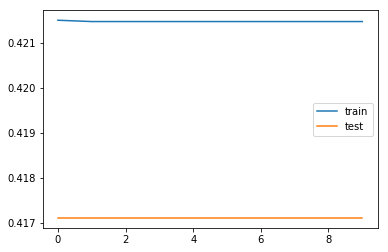

Test RMSE: 360.502


In [8]:
model.add(LSTM(70,  dropout=0.2, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1, activation='relu'))

model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=10, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)